In [1]:
#colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
torch.cuda.device_count()

1

In [3]:
ls "/content/drive/MyDrive/Colab Notebooks/도시빅데이터응용/data_seg/train/images"


0.png   12.png  15.png  18.png  20.png  23.png  26.png  4.png  7.png
10.png  13.png  16.png  19.png  21.png  24.png  2.png   5.png  8.png
11.png  14.png  17.png  1.png   22.png  25.png  3.png   6.png  9.png


In [4]:
data_path = '/content/drive/MyDrive/Colab Notebooks/도시빅데이터응용/data_seg/'

In [24]:
import numpy as np
import os
from PIL import Image 
import matplotlib.pyplot as plt
input_image = Image.open(data_path + '/train/images/0.png')
label_image = Image.open(data_path +'/train/masks/0.png')


<bound method Image.show of <PIL.PngImagePlugin.PngImageFile image mode=L size=512x512 at 0x7F8F25E70BD0>>

Text(0.5, 1.0, 'label')

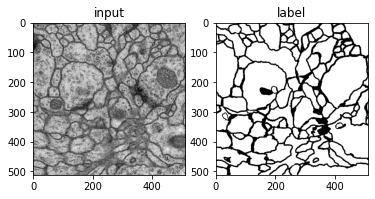

In [6]:
plt.subplot(121)
plt.imshow(input_image, cmap= 'gray')
plt.title('input')

plt.subplot(122)
plt.imshow(label_image, cmap = 'gray')
plt.title('label')

* preprocessing

In [7]:
import numpy as np
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter
from random import randint


def add_elastic_transform(image, alpha, sigma, pad_size=30, seed=None):
    """
    Args:
        image : numpy array of image
        alpha : α is a scaling factor
        sigma :  σ is an elasticity coefficient
        random_state = random integer
        Return :
        image : elastically transformed numpy array of image
    """
    image_size = int(image.shape[0])
    image = np.pad(image, pad_size, mode="symmetric")
    if seed is None:
        seed = randint(1, 100)
        random_state = np.random.RandomState(seed)
    else:
        random_state = np.random.RandomState(seed)
    shape = image.shape
    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1),  sigma, mode="constant", cval=0) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha

    x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
    indices = np.reshape(y+dy, (-1, 1)), np.reshape(x+dx, (-1, 1))
    return cropping(map_coordinates(image, indices, order=1).reshape(shape), 512, pad_size, pad_size), seed


def flip(image, option_value):
    """
    Args:
        image : numpy array of image
        option_value = random integer between 0 to 3
    Return :
        image : numpy array of flipped image
    """
    if option_value == 0:
        # vertical
        image = np.flip(image, option_value)
    elif option_value == 1:
        # horizontal
        image = np.flip(image, option_value)
    elif option_value == 2:
        # horizontally and vertically flip
        image = np.flip(image, 0)
        image = np.flip(image, 1)
    else:
        image = image
        # no effect
    return image


def add_gaussian_noise(image, mean=0, std=1):
    """
    Args:
        image : numpy array of image
        mean : pixel mean of image
        standard deviation : pixel standard deviation of image
    Return :
        image : numpy array of image with gaussian noise added
    """
    gaus_noise = np.random.normal(mean, std, image.shape)
    image = image.astype("int16")
    noise_img = image + gaus_noise
    image = ceil_floor_image(image)
    return noise_img


def add_uniform_noise(image, low=-10, high=10):
    """
    Args:
        image : numpy array of image
        low : lower boundary of output interval
        high : upper boundary of output interval
    Return :
        image : numpy array of image with uniform noise added
    """
    uni_noise = np.random.uniform(low, high, image.shape)
    image = image.astype("int16")
    noise_img = image + uni_noise
    image = ceil_floor_image(image)
    return noise_img


def change_brightness(image, value):
    """
    Args:
        image : numpy array of image
        value : brightness
    Return :
        image : numpy array of image with brightness added
    """
    image = image.astype("int16")
    image = image + value
    image = ceil_floor_image(image)
    return image


def ceil_floor_image(image):
    """
    Args:
        image : numpy array of image in datatype int16
    Return :
        image : numpy array of image in datatype uint8 with ceilling(maximum 255) and flooring(minimum 0)
    """
    image[image > 255] = 255
    image[image < 0] = 0
    image = image.astype("uint8")
    return image


def approximate_image(image):
    """
    Args:
        image : numpy array of image in datatype int16
    Return :
        image : numpy array of image in datatype uint8 only with 255 and 0
    """
    image[image > 127.5] = 255
    image[image < 127.5] = 0
    image = image.astype("uint8")
    return image


def normalization1(image, mean, std):
    """ Normalization using mean and std
    Args :
        image : numpy array of image
        mean :
    Return :
        image : numpy array of image with values turned into standard scores
    """

    image = image / 255  # values will lie between 0 and 1.
    image = (image - mean) / std

    return image


def normalization2(image, max, min):
    """Normalization to range of [min, max]
    Args :
        image : numpy array of image
        mean :
    Return :
        image : numpy array of image with values turned into standard scores
    """
    image_new = (image - np.min(image))*(max - min)/(np.max(image)-np.min(image)) + min
    return image_new


def stride_size(image_len, crop_num, crop_size):
    """return stride size
    Args :
        image_len(int) : length of one size of image (width or height)
        crop_num(int) : number of crop in certain direction
        crop_size(int) : size of crop
    Return :
        stride_size(int) : stride size
    """
    return int((image_len - crop_size)/(crop_num - 1))


def multi_cropping(image, crop_size, crop_num1, crop_num2):
    """crop the image and pad it to in_size
    Args :
        images : numpy arrays of images
        crop_size(int) : size of cropped image
        crop_num2 (int) : number of crop in horizontal way
        crop_num1 (int) : number of crop in vertical way
    Return :
        cropped_imgs : numpy arrays of stacked images
    """

    img_height, img_width = image.shape[0], image.shape[1]
    assert crop_size*crop_num1 >= img_width and crop_size * \
        crop_num2 >= img_height, "Whole image cannot be sufficiently expressed"
    assert crop_num1 <= img_width - crop_size + 1 and crop_num2 <= img_height - \
        crop_size + 1, "Too many number of crops"

    cropped_imgs = []
    # int((img_height - crop_size)/(crop_num1 - 1))
    dim1_stride = stride_size(img_height, crop_num1, crop_size)
    # int((img_width - crop_size)/(crop_num2 - 1))
    dim2_stride = stride_size(img_width, crop_num2, crop_size)
    for i in range(crop_num1):
        for j in range(crop_num2):
            cropped_imgs.append(cropping(image, crop_size,
                                         dim1_stride*i, dim2_stride*j))
    return np.asarray(cropped_imgs)


# IT IS NOT USED FOR PAD AND CROP DATA OPERATION
# IF YOU WANT TO USE CROP AND PAD USE THIS FUNCTION
"""
def multi_padding(images, in_size, out_size, mode):
    '''Pad the images to in_size
    Args :
        images : numpy array of images (CxHxW)
        in_size(int) : the input_size of model (512)
        out_size(int) : the output_size of model (388)
        mode(str) : mode of padding
    Return :
        padded_imgs: numpy arrays of padded images
    '''
    pad_size = int((in_size - out_size)/2)
    padded_imgs = []
    for num in range(images.shape[0]):
        padded_imgs.append(add_padding(images[num], in_size, out_size, mode=mode))
    return np.asarray(padded_imgs)

"""


def cropping(image, crop_size, dim1, dim2):
    """crop the image and pad it to in_size
    Args :
        images : numpy array of images
        crop_size(int) : size of cropped image
        dim1(int) : vertical location of crop
        dim2(int) : horizontal location of crop
    Return :
        cropped_img: numpy array of cropped image
    """
    cropped_img = image[dim1:dim1+crop_size, dim2:dim2+crop_size]
    return cropped_img


def add_padding(image, in_size, out_size, mode):
    """Pad the image to in_size
    Args :
        images : numpy array of images
        in_size(int) : the input_size of model
        out_size(int) : the output_size of model
        mode(str) : mode of padding
    Return :
        padded_img: numpy array of padded image
    """
    pad_size = int((in_size - out_size)/2)
    padded_img = np.pad(image, pad_size, mode=mode)
    return padded_img


def division_array(crop_size, crop_num1, crop_num2, dim1, dim2):
    """Make division array
    Args :
        crop_size(int) : size of cropped image
        crop_num2 (int) : number of crop in horizontal way
        crop_num1 (int) : number of crop in vertical way
        dim1(int) : vertical size of output
        dim2(int) : horizontal size_of_output
    Return :
        div_array : numpy array of numbers of 1,2,4
    """
    div_array = np.zeros([dim1, dim2])  # make division array
    one_array = np.ones([crop_size, crop_size])  # one array to be added to div_array
    dim1_stride = stride_size(dim1, crop_num1, crop_size)  # vertical stride
    dim2_stride = stride_size(dim2, crop_num2, crop_size)  # horizontal stride
    for i in range(crop_num1):
        for j in range(crop_num2):
            # add ones to div_array at specific position
            div_array[dim1_stride*i:dim1_stride*i + crop_size,
                      dim2_stride*j:dim2_stride*j + crop_size] += one_array
    return div_array


def image_concatenate(image, crop_num1, crop_num2, dim1, dim2):
    """concatenate images
    Args :
        image : output images (should be square)
        crop_num2 (int) : number of crop in horizontal way (2)
        crop_num1 (int) : number of crop in vertical way (2)
        dim1(int) : vertical size of output (512)
        dim2(int) : horizontal size_of_output (512)
    Return :
        div_array : numpy arrays of numbers of 1,2,4
    """
    crop_size = image.shape[1]  # size of crop
    empty_array = np.zeros([dim1, dim2]).astype("float64")  # to make sure no overflow
    dim1_stride = stride_size(dim1, crop_num1, crop_size)  # vertical stride
    dim2_stride = stride_size(dim2, crop_num2, crop_size)  # horizontal stride
    index = 0
    for i in range(crop_num1):
        for j in range(crop_num2):
            # add image to empty_array at specific position
            empty_array[dim1_stride*i:dim1_stride*i + crop_size,
                        dim2_stride*j:dim2_stride*j + crop_size] += image[index]
            index += 1
    return empty_array



* Start To Training


In [8]:
import numpy as np
from PIL import Image
import glob
import torch
import torch.nn as nn
from torch.autograd import Variable
from random import randint
from torch.utils.data.dataset import Dataset
#from pre_processing import *
#from mean_std import *

* DatasetLoader with Augment
  - flip
  - Noise Determine - 0: Gaussian_noise, 1: uniform_noise
  - Brightness
  - Elastic distort - 0: distort, 1:no distort 
  - Crop the image
  - Normalize the image

Text(0.5, 1.0, 'label')

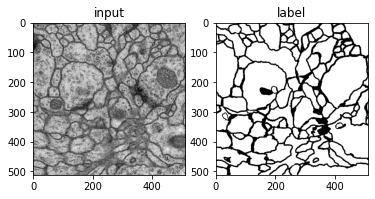

In [9]:
input_image = Image.open(data_path + '/train/images/0.png')
label_image = Image.open(data_path +'/train/masks/0.png')
plt.subplot(121)
plt.imshow(input_image, cmap= 'gray')
plt.title('input')

plt.subplot(122)
plt.imshow(label_image, cmap = 'gray')
plt.title('label')

In [22]:
input_image.show()

In [30]:
img_as_img = input_image
img_as_np = np.asarray(img_as_img)

In [32]:
# Elastic distort {0: distort, 1:no distort}
sigma = randint(6, 12)
# sigma = 4, alpha = 34
img_as_np_aug, seed = add_elastic_transform(img_as_np, alpha=34, sigma=sigma, pad_size=20)
image_aug = Image.fromarray(img_as_np_aug)
print(img_as_np)
print(img_as_np_aug)

[[126 107 122 ... 161 164 177]
 [138 118 123 ... 153 149 153]
 [141 135 145 ... 144 145 137]
 ...
 [155 149 168 ... 139 115 120]
 [163 154 166 ... 158 141 148]
 [151 141 160 ... 183 164 171]]
[[127 123 109 ... 162 162 162]
 [139 137 122 ... 155 155 152]
 [132 132 132 ... 141 146 145]
 ...
 [167 167 173 ... 108 113 112]
 [157 153 169 ... 130 136 135]
 [160 152 166 ... 157 163 160]]


Text(0.5, 1.0, 'elastic')

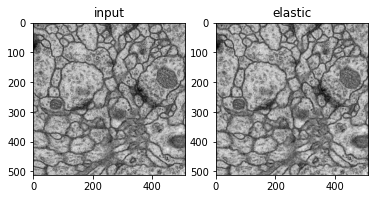

In [33]:
plt.subplot(121)
plt.imshow(input_image, cmap= 'gray')
plt.title('input')

plt.subplot(122)
plt.imshow(image_aug, cmap = 'gray')
plt.title('elastic')

In [39]:
# Augmentation
# flip {0: vertical, 1: horizontal, 2: both, 3: none}
flip_num = randint(0, 3)
img_as_np_aug = flip(img_as_np, flip_num)
image_aug = Image.fromarray(img_as_np_aug)
print(flip_num)

0


Text(0.5, 1.0, 'flip')

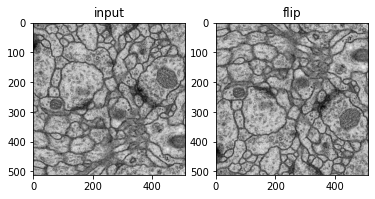

In [40]:
plt.subplot(121)
plt.imshow(input_image, cmap= 'gray')
plt.title('input')

plt.subplot(122)
plt.imshow(image_aug, cmap = 'gray')
plt.title('flip')

In [42]:
# Brightness
pix_add = randint(-20, 20)
img_as_np = change_brightness(img_as_np, pix_add)
img_as_np_aug = flip(img_as_np, flip_num)
image_aug = Image.fromarray(img_as_np_aug)
print(pix_add)

5


Text(0.5, 1.0, 'Brightness')

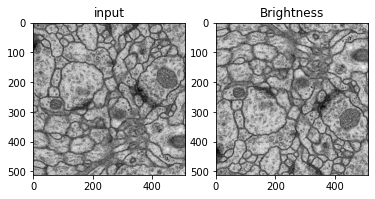

In [43]:
plt.subplot(121)
plt.imshow(input_image, cmap= 'gray')
plt.title('input')

plt.subplot(122)
plt.imshow(image_aug, cmap = 'gray')
plt.title('Brightness')

In [48]:
# Gaussian_noise
gaus_sd, gaus_mean = randint(0, 20), 0
img_as_np_aug = add_gaussian_noise(img_as_np, gaus_mean, gaus_sd)
image_aug = Image.fromarray(img_as_np_aug)
print(gaus_sd, gaus_mean)

10 0


Text(0.5, 1.0, 'Gaussian_noise')

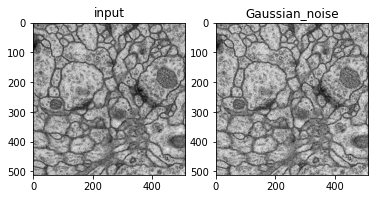

In [49]:
plt.subplot(121)
plt.imshow(input_image, cmap= 'gray')
plt.title('input')

plt.subplot(122)
plt.imshow(image_aug, cmap = 'gray')
plt.title('Gaussian_noise')

In [50]:
# uniform_noise
l_bound, u_bound = randint(-20, 0), randint(0, 20)
img_as_np_aug = add_uniform_noise(img_as_np, l_bound, u_bound)
image_aug = Image.fromarray(img_as_np_aug)
print(gaus_sd, gaus_mean)

10 0


Text(0.5, 1.0, 'uniform_noise')

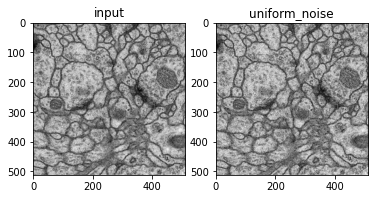

In [52]:
plt.subplot(121)
plt.imshow(input_image, cmap= 'gray')
plt.title('input')

plt.subplot(122)
plt.imshow(image_aug, cmap = 'gray')
plt.title('uniform_noise')

In [70]:

img_as_np_aug =cropping(img_as_np,  100, 30, 30)
image_aug = Image.fromarray(img_as_np_aug)


Text(0.5, 1.0, 'crop')

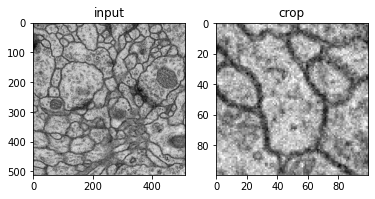

In [71]:
plt.subplot(121)
plt.imshow(input_image, cmap= 'gray')
plt.title('input')

plt.subplot(122)
plt.imshow(image_aug, cmap = 'gray')
plt.title('crop')